# 전국 도시 공원 표준 데이터
https://www.data.go.kr/dataset/15012890/standard.do
* 전국 도시공원에 대한 분포를 시각화해 봅니다.
* 어떤 공원이 어느 지역에 어떻게 분포되어 있는지를 경도로 표현해 봅니다.
* 실습을 위해 나눔고딕 폰트가 설치되어 있어야 합니다.
* 이 노트북에서는 pandas, plotnine을 사용합니다.

## 그 외 도시공원 데이터
* 공공데이터 포털에 확인해 보니 전국도시공원표준데이터.xls 외에 202개의 파일이 더 있습니다. 
* https://www.data.go.kr/dataset/15012890/standard.do

## 분석에 사용할 도구를 불러옵니다.

In [1]:
# !pip show pandas

In [2]:
# !pip show numpy

In [3]:
# !pip show plotnine

In [4]:
# !pip show folium

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import numpy as np
from plotnine import *
import re

# 지도 표현을 위해
import folium

## 데이터 로드

In [7]:
park = pd.read_csv('data/전국도시공원표준데이터.csv', encoding='euc-kr')
park.shape

(13135, 18)

In [8]:
park.head(7)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN
5,42800-00006,상리공원3,어린이공원,강원도 양구군 양구읍 상리 275-5,강원도 양구군 양구읍 상리 275-5,38.106175,127.990675,1768,NaN,NaN,NaN,NaN,NaN,2012-07-06,강원도 양구군청,033-480-2927,2018-02-28,NaN
6,27170-00001,이현공원,근린공원,NaN,대구광역시 서구 이현동 산28-12,35.873385,128.543472,109324,"운동장, 수영장, 야외운동시설",NaN,화장실,NaN,NaN,1965-02-02,대구광역시 서구청,053-663-2866,2018-02-20,NaN


In [9]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 18 columns):
관리번호            13135 non-null object
공원명             13135 non-null object
공원구분            13135 non-null object
소재지도로명주소        7237 non-null object
소재지지번주소         11931 non-null object
위도              13129 non-null float64
경도              13129 non-null float64
공원면적            13108 non-null object
공원보유시설(운동시설)    3556 non-null object
공원보유시설(유희시설)    4717 non-null object
공원보유시설(편익시설)    3463 non-null object
공원보유시설(교양시설)    753 non-null object
공원보유시설(기타시설)    2095 non-null object
지정고시일           11196 non-null object
관리기관명           12352 non-null object
전화번호            12210 non-null object
데이터기준일자         13135 non-null object
Unnamed: 17     0 non-null float64
dtypes: float64(3), object(15)
memory usage: 1.8+ MB


In [10]:
park.isnull().sum()

관리번호                0
공원명                 0
공원구분                0
소재지도로명주소         5898
소재지지번주소          1204
위도                  6
경도                  6
공원면적               27
공원보유시설(운동시설)     9579
공원보유시설(유희시설)     8418
공원보유시설(편익시설)     9672
공원보유시설(교양시설)    12382
공원보유시설(기타시설)    11040
지정고시일            1939
관리기관명             783
전화번호              925
데이터기준일자             0
Unnamed: 17     13135
dtype: int64

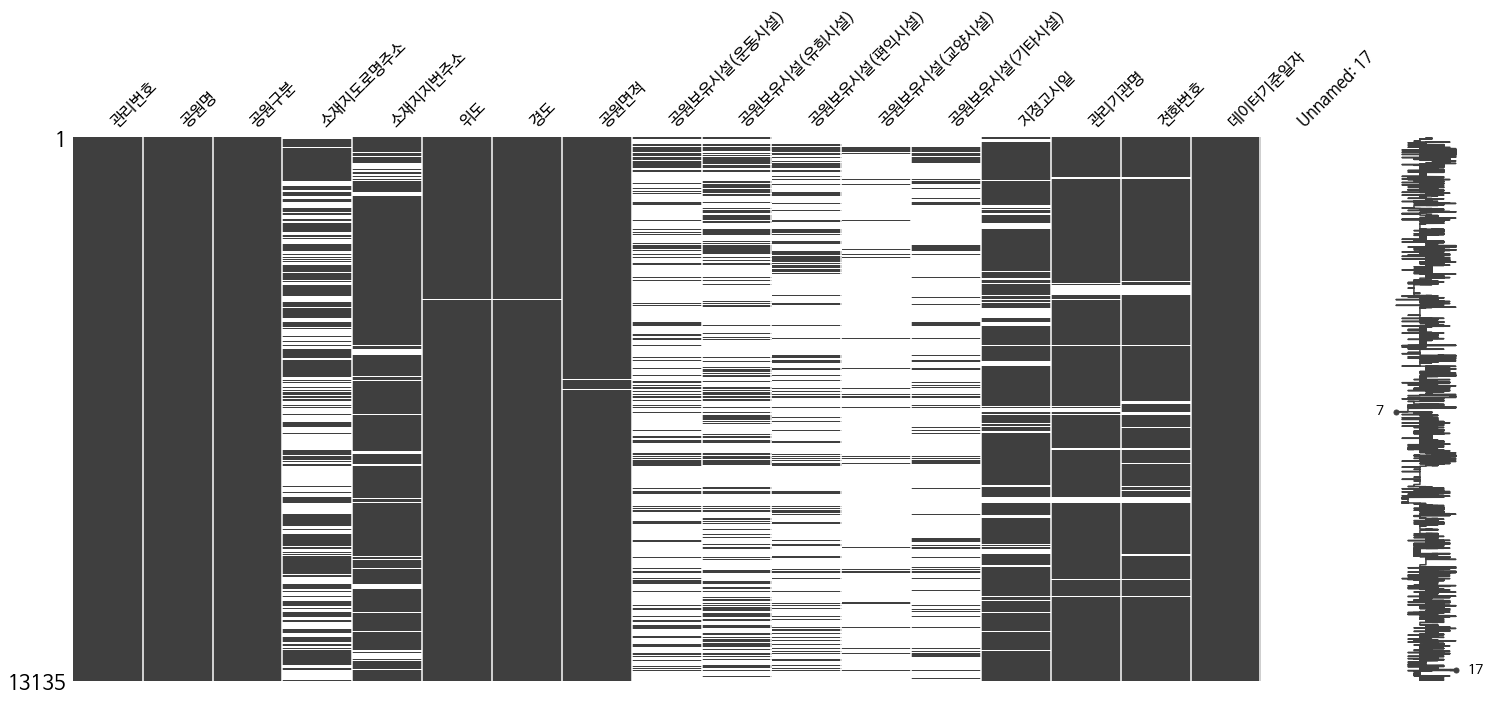

In [11]:
import missingno as msno

msno.matrix(park)

## 불필요한 컬럼 제거하기

In [12]:
park.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', '전화번호', '데이터기준일자', 'Unnamed: 17'],
      dtype='object')

In [13]:
#park.drop?

In [14]:
park.drop(columns=['공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', 'Unnamed: 17'], inplace=True)

In [15]:
park.shape

(13135, 10)

## 위경도 시각화

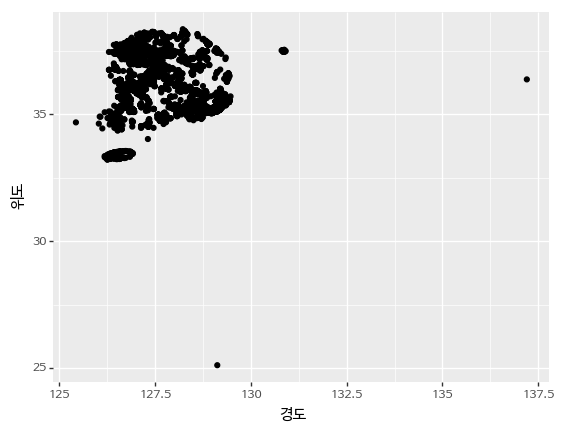

<ggplot: (293685494)>

In [16]:
# 지도를 출력해 보니 특정 지역만 있습니다.
# 결측치인 nan 데이터 때문에 다른 데이터가 제대로 보이지 않습니다.
# nan 데이터를 제거하고 다시 그려봅니다.
(ggplot(park)
 + aes(x='경도', y='위도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

# 데이터 전처리
* 시도 결측치 처리
    * 다른 데이터로 대체
    * 도로명 혹은 지번 둘 중 하나만 있다면 있는 데이터로 대체
* 아웃라이어 데이터 제거 혹은 대체
    * 위경도가 국내 범위를 벗어나는 데이터의 경우 제외하고 그리도록 처리

In [17]:
park.dtypes

관리번호         object
공원명          object
공원구분         object
소재지도로명주소     object
소재지지번주소      object
위도          float64
경도          float64
공원면적         object
전화번호         object
데이터기준일자      object
dtype: object

In [18]:
park['공원면적'] = park['공원면적'].str.replace(',', '').astype(float)
park['공원면적'].head()

0      1597.0
1      1498.0
2      1499.0
3     18437.0
4    178931.0
Name: 공원면적, dtype: float64

In [19]:
park['공원면적비율'] = park['공원면적'].apply(lambda x : np.sqrt(x)*0.01)
park['공원면적비율'].head()

0    0.399625
1    0.387040
2    0.387169
3    1.357829
4    4.230024
Name: 공원면적비율, dtype: float64

In [20]:
# 도로명 주소의 널값 수
park['소재지도로명주소'].isnull().sum()

5898

In [21]:
# 지번 주소의 널값 수
park['소재지지번주소'].isnull().sum()

1204

In [22]:
park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())].shape

(5898, 11)

In [23]:
park['소재지도로명주소'].fillna(park['소재지지번주소'], inplace = True)

In [24]:
park['소재지도로명주소'].isnull().sum()

0

In [25]:
park_loc = park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())]
park_loc.shape

(0, 11)

In [26]:
park['시도'] = park['소재지도로명주소'].str.split(' ', expand=True)[0]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597.0,033-480-2927,2018-02-28,0.399625,강원도
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498.0,033-480-2927,2018-02-28,0.387040,강원도
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499.0,033-480-2927,2018-02-28,0.387169,강원도


In [27]:
park['구군'] = park['소재지도로명주소'].str.split(' ', expand=True)[1]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597.0,033-480-2927,2018-02-28,0.399625,강원도,양구군
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498.0,033-480-2927,2018-02-28,0.387040,강원도,양구군
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499.0,033-480-2927,2018-02-28,0.387169,강원도,양구군


In [28]:
# park.describe?

In [29]:
park[['위도', '경도']].describe()

,위도,경도
count,13129.000000,13129.000000
mean,36.493476,127.555095
std,1.066760,0.870196
min,25.115601,125.432215
25%,35.568188,126.929027
50%,36.637676,127.141569
75%,37.460255,128.213060
max,38.350990,137.202661


In [30]:
# 위 지도로 위도와 경도의 아웃라이어 데이터를 제외하고 출력해 봅니다.
# 좀 더 정확하게 출력하려면 대한민국 위경도 데이터 범위를 다시 넣어줍니다. 
park_loc_notnull = park.loc[(park['위도'] > 32 ) & (park['경도'] < 132) & park['시도'].notnull()]
park_loc_notnull.shape

(13127, 13)

In [31]:
# 위경도가 잘못입력된 데이터를 봅니다.
# 주소가 잘못되지는 않았습니다.
# 주소를 통해 위경도를 다시 받아올 필요가 있습니다.
park.loc[(park['위도'] < 26 ) | (park['경도'] >= 132)]

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
7768,26710-00002,굿거리언덕공원,근린공원,부산광역시 기장군 기장읍 내리 800,부산광역시 기장군 기장읍 내리 800,25.115601,129.122735,12124.3,051-709-4531,2017-08-25,1.101104,부산광역시,기장군
8175,43113-00080,근린공원5(만수공원),근린공원,충청북도 청주시 흥덕구 오송읍 만수리 512,충청북도 청주시 흥덕구 오송읍 만수리 512,36.374204,137.202661,33258.0,043-201-7233,2017-04-01,1.823678,충청북도,청주시


In [32]:
park_loc_notnull['시도'].value_counts()

경기도        3675
서울특별시      1226
전라북도       1076
충청북도        904
경상남도        881
울산광역시       822
강원도         623
전라남도        623
부산광역시       610
경상북도        465
충청남도        457
대구광역시       454
대전광역시       421
인천광역시       292
광주광역시       276
제주특별자치도     252
세종특별자치시      70
Name: 시도, dtype: int64

# 시도별 공원 데이터

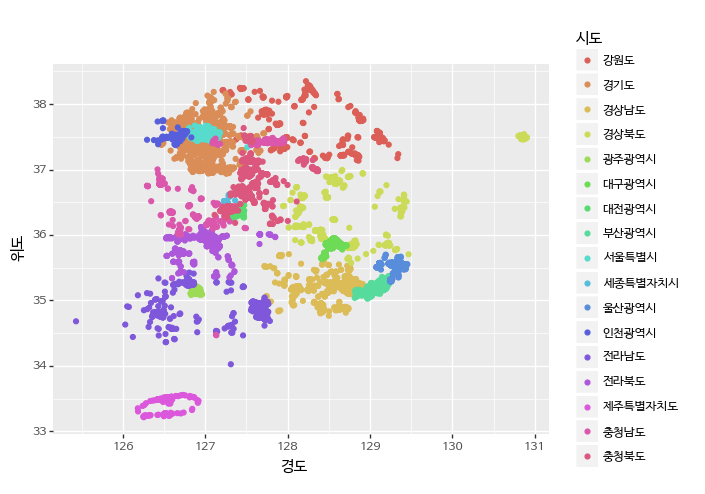

<ggplot: (293125170)>

In [33]:
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='시도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

### 공원구분별 분포

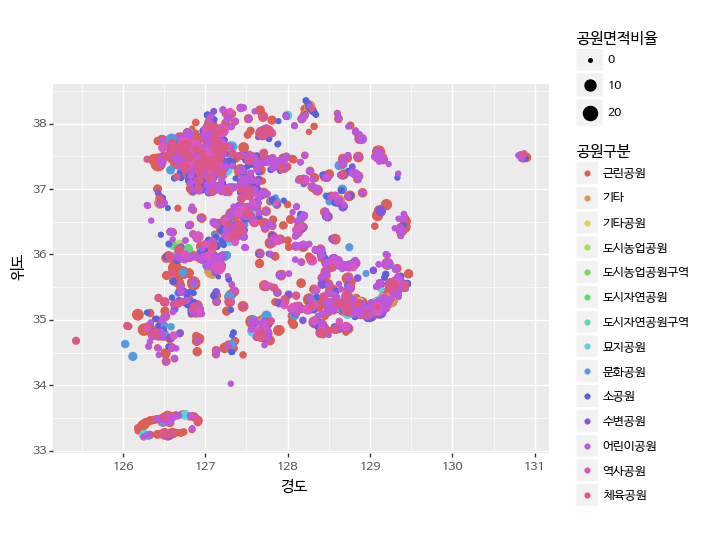

<ggplot: (293081022)>

In [34]:
# 전국적으로 어린이 공원이 가장 많은 것으로 보입니다.
# 제주도는 한라산 아래 해안선과 유사한 모습으로 공원이 배치되어 있는 모습이 인상적입니다.
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='공원구분', size='공원면적비율')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

### 어린이 공원을 제외한  공원구분별 분포도

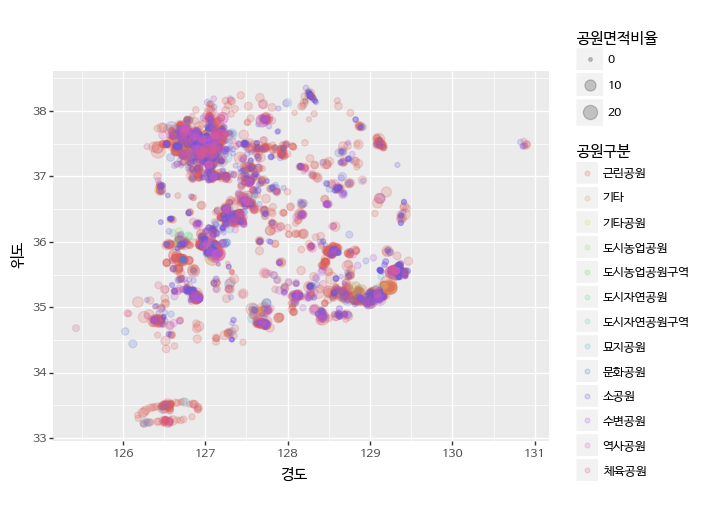

<ggplot: (-9223372036561648352)>

In [35]:
# 어린이공원을 제외하고 찍어보도록 합니다.
# 다음으로 많은 근린공원과 소공원이 많이 보입니다.
(ggplot(park_loc_notnull.loc[park_loc_notnull['공원구분'] != '어린이공원'])
 + aes(x='경도', y='위도', color='공원구분', size='공원면적비율')
 + geom_point(alpha=0.2)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [36]:
park_loc_notnull.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597.0,033-480-2927,2018-02-28,0.399625,강원도,양구군
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498.0,033-480-2927,2018-02-28,0.387040,강원도,양구군
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499.0,033-480-2927,2018-02-28,0.387169,강원도,양구군
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437.0,033-480-2460,2018-02-28,1.357829,강원도,양구군
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931.0,033-480-2576,2018-02-28,4.230024,강원도,양구군


### 시도별 공원 비율

In [37]:
# 시도별로 합계 데이터를 출력
park_do = pd.DataFrame(park['시도'].value_counts())
park_do_normalize = pd.DataFrame(park['시도'].value_counts(normalize=True))
park_sido = park_do.merge(park_do_normalize, left_index=True, right_index=True).reset_index()
park_sido.columns = ['시도', '합계', '비율']
park_sido.sort_values(by=['합계'], ascending=False)
park_sido

,시도,합계,비율
0,경기도,3675,0.279787
1,서울특별시,1230,0.093643
2,전라북도,1076,0.081919
3,충청북도,905,0.068900
4,경상남도,881,0.067073
5,울산광역시,822,0.062581
6,강원도,623,0.047431
7,전라남도,623,0.047431
8,부산광역시,613,0.046669
9,경상북도,465,0.035402


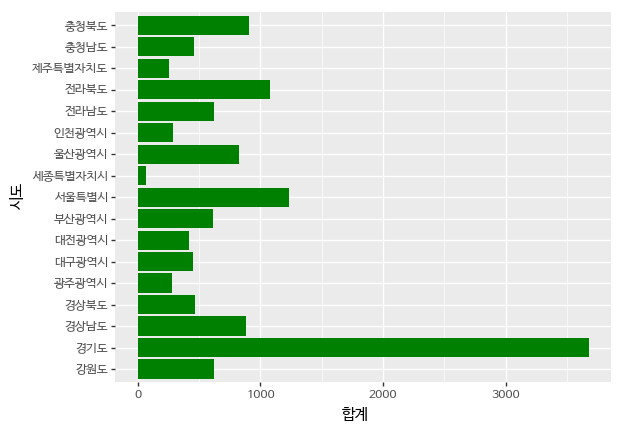

<ggplot: (-9223372036561087095)>

In [38]:
# 경기도가 압도적으로 많음
(ggplot(park_sido.sort_values(by=['합계'], ascending=False))
 + aes(x='시도', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [39]:
park_type = park['공원구분'].value_counts().reset_index()
park_type.columns = ('공원구분', '합계')
park_type

,공원구분,합계
0,어린이공원,7375
1,근린공원,3148
2,소공원,1723
3,문화공원,205
4,수변공원,199
5,체육공원,162
6,기타,159
7,역사공원,115
8,묘지공원,35
9,도시자연공원,5


### 공원구분별 합계

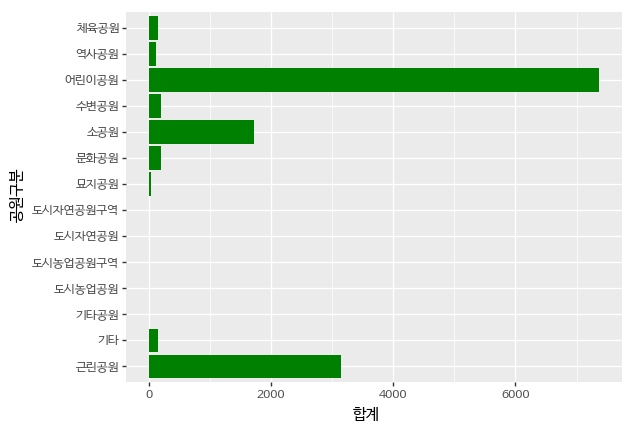

<ggplot: (-9223372036562517346)>

In [40]:
(ggplot(park_type)
 + aes(x='공원구분', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 경기도
* 경기도에는 가장 많은 공원이 있습니다. 
* 어떻게 분포되어 있는지 보겠습니다.

In [41]:
gg = park.loc[park['시도'] == '경기도']
gg.shape

(3675, 13)

In [42]:
gg_park = gg['공원구분'].value_counts().reset_index()
gg_park.columns = ('공원구분', '합계')
gg_park

,공원구분,합계
0,어린이공원,2037
1,근린공원,894
2,소공원,475
3,문화공원,76
4,체육공원,73
5,수변공원,64
6,역사공원,34
7,묘지공원,12
8,기타,10


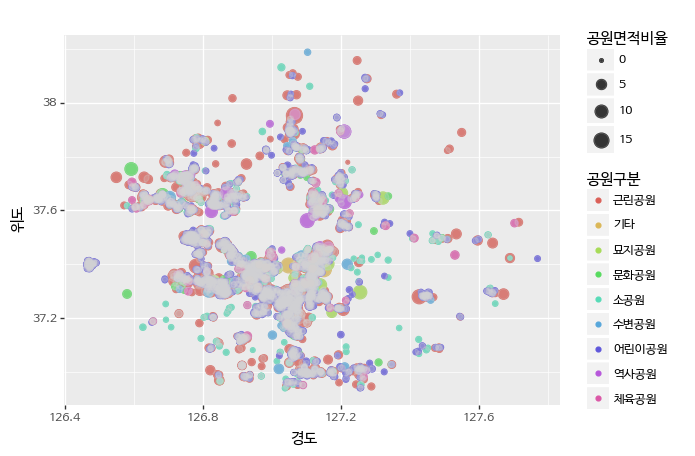

<ggplot: (-9223372036561505336)>

In [43]:
(ggplot(gg)
 + aes(x='경도', y='위도', color='공원구분', size='공원면적비율') 
 + geom_point()
 + geom_jitter(color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [44]:
gg_suwon = gg.loc[gg['구군'] == '수원시']

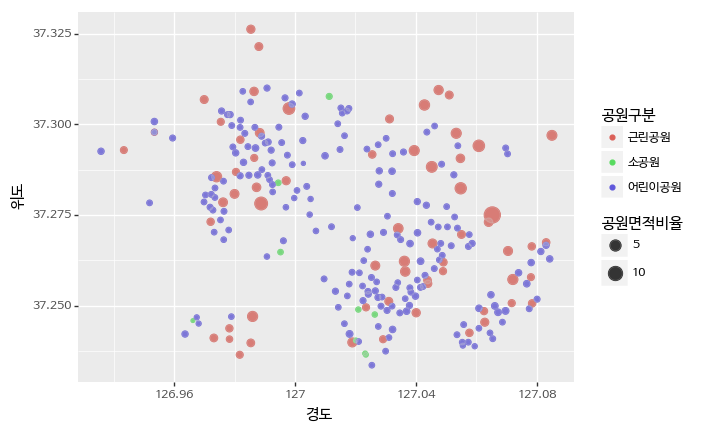

<ggplot: (293837832)>

In [45]:
(ggplot(gg_suwon)
 + aes(x='경도', y='위도', color='공원구분', size='공원면적비율') 
 + geom_point()
 + geom_jitter(color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [46]:
geo_df = gg_suwon
map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=13)

for n in geo_df.index:
    park_name = geo_df.loc[n, '공원명'] + '-' + geo_df.loc[n, '소재지도로명주소']
    icon_color = 'blue'
    folium.features.CircleMarker(
        location=[geo_df.loc[n, '위도'], geo_df.loc[n, '경도']],
        radius=geo_df['공원면적비율'][n],
        popup=park_name,
        color=icon_color,
        fill=True,
        fill_color=icon_color
    ).add_to(map)
    
map

전체 공원을 다 찍어 보면 너무 많아서 잘 구분이 안 되기 때문에 몇 가지 공원만 따로 찍어 봅니다.

## 경기도 일부 공원만 보기

In [47]:
park_type = r'.*((역사|체육|수변|문화|묘지)공원).*'
gg_sample = gg.loc[gg['공원구분'].str.match(park_type)]

In [48]:
gg_sample.shape

(259, 13)

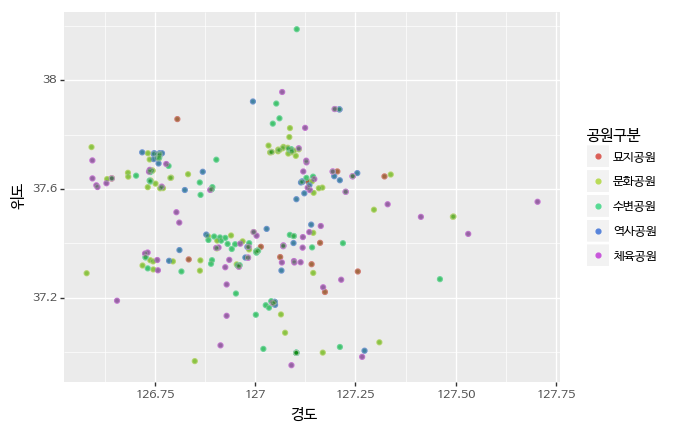

<ggplot: (294817975)>

In [49]:
(ggplot(gg_sample)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + geom_jitter(fill='green', color='lightgray', alpha=0.25)
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [50]:
gg_sample.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
463,41220-00057,현촌한마음공원,문화공원,경기도 평택시 용이동 596-7,경기도 평택시 용이동 596-7,36.966736,126.849719,6694.0,031-8024-4241,2018-02-19,0.818169,경기도,평택시
464,41220-00058,물빛수변공원1,수변공원,경기도 평택시 비전동 999,경기도 평택시 비전동 999,36.997279,127.102611,39061.0,031-8024-4241,2018-02-19,1.976386,경기도,평택시
465,41220-00059,물빛수변공원2,수변공원,경기도 평택시 비전동 1016,경기도 평택시 비전동 1016,36.997279,127.102611,11228.0,031-8024-4241,2018-02-19,1.059623,경기도,평택시


In [51]:
# 경기도 일부 공원만 지도에 표기
geo_df = gg_sample

map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=11)

for n in geo_df.index:
    park_name = geo_df.loc[n, '공원명'] + ' - ' + geo_df.loc[n, '소재지도로명주소']
    folium.Marker([geo_df.loc[n, '위도'], geo_df.loc[n, '경도']], popup=park_name).add_to(map)
    
map

## 서울특별시

In [52]:
seoul = park[park['시도'] == '서울특별시']
seoul.shape

(1230, 13)

In [53]:
seoul.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
804,11680-00035,반달근린공원,근린공원,서울특별시 강남구 삼성동 7-4,서울특별시 강남구 삼성동 7-4,37.516700,127.040616,679.3,02-3423-6245,2017-11-16,0.260634,서울특별시,강남구
1024,11680-00036,샘터근린공원,근린공원,서울특별시 강남구 삼성동 16-4,서울특별시 강남구 삼성동 16-4,37.514379,127.060169,1799.5,02-3423-6245,2017-11-16,0.424205,서울특별시,강남구
1202,11680-00037,학봉근린공원,근린공원,서울특별시 강남구 삼성동 50-3,서울특별시 강남구 삼성동 50-3,37.510470,127.053987,1343.0,02-3423-6245,2017-11-16,0.366470,서울특별시,강남구
1265,11680-00038,큰골근린공원,근린공원,서울특별시 강남구 대치동 888-3,서울특별시 강남구 대치동 888-3,37.494313,127.050370,1688.1,02-3423-6245,2017-11-16,0.410865,서울특별시,강남구
1278,11680-00039,새뜰근린공원,근린공원,서울특별시 강남구 역삼동 765-30,서울특별시 강남구 역삼동 765-30,37.497183,127.046607,427.6,02-3423-6245,2017-11-16,0.206785,서울특별시,강남구


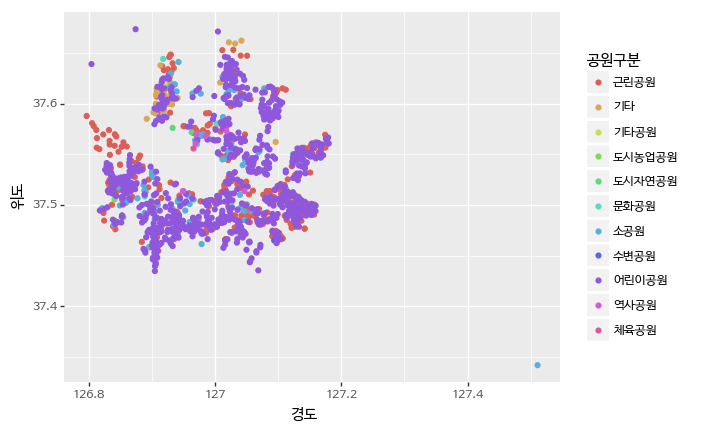

<ggplot: (-9223372036559937357)>

In [54]:
(ggplot(seoul)
 + aes(x='경도', y='위도', color='공원구분') 
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [55]:
seoul[seoul["경도"] > 127.4]

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
8399,11260-00051,코오롱하늘채앞소공원,소공원,서울특별시 중랑구 면목동 1537-1,서울특별시 중랑구 면목동 1537-1,37.341883,127.51097,1221.8,02-2094-2364,2017-10-11,0.349543,서울특별시,중랑구


In [56]:
seoul['공원구분'].value_counts()

어린이공원     763
근린공원      292
소공원       113
기타         42
역사공원        6
문화공원        6
수변공원        3
도시자연공원      2
도시농업공원      1
기타공원        1
체육공원        1
Name: 공원구분, dtype: int64

In [57]:
seoul_playground = park.loc[(park['공원구분'] == '어린이공원') & (park['시도'] == '서울특별시')]
seoul_playground.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,공원면적비율,시도,구군
1476,11680-00056,논현목련공원,어린이공원,서울특별시 강남구 논현동 137-18,서울특별시 강남구 논현동 137-18,37.510851,127.017942,986.0,02-3423-6247,2017-11-16,0.314006,서울특별시,강남구
1646,11380-00050,다래어린이공원,어린이공원,서울특별시 은평구 응암동 115-55,"서울특별시 은평구 응암동 751-22, 23",37.587111,126.919033,584.9,02-350-5254,2017-07-12,0.241847,서울특별시,은평구
1648,11380-00052,응암9구역어린이공원,어린이공원,서울특별시 은평구 응암동 115-57,서울특별시 은평구 응암동670-25외16필지,37.586731,126.923094,1217.8,02-350-5254,2017-07-12,0.348970,서울특별시,은평구
1741,11380-00071,시내어린이공원,어린이공원,서울특별시 은평구 응암동 115-76,서울특별시 은평구 불광동 444-15,37.624806,126.927410,659.0,02-350-5254,2017-07-12,0.256710,서울특별시,은평구
1742,11380-00072,가람어린이공원,어린이공원,서울특별시 은평구 응암동 115-77,서울특별시 은평구 불광동 448-11,37.626369,126.925398,249.0,02-350-5254,2017-07-12,0.157797,서울특별시,은평구


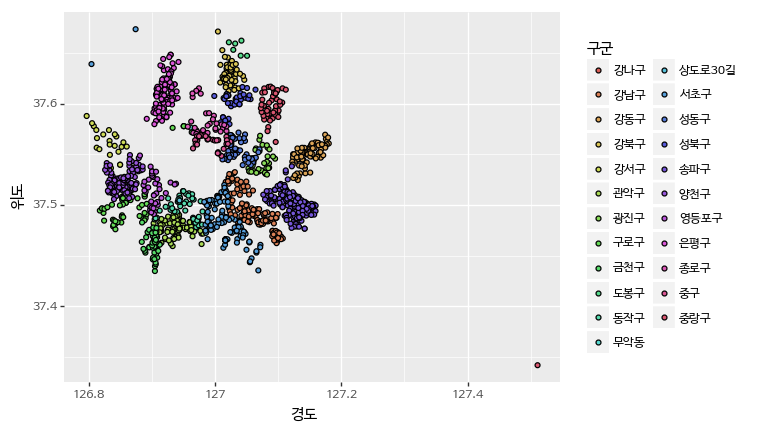

<ggplot: (294838287)>

In [58]:
(ggplot(seoul)
 + aes(x='경도', y='위도', fill='구군')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

## 구별 공원 분포

In [59]:
gu = '강남구 강동구 강북구 강서구 관악구 광진구 구로구 금천구 노원구 도봉구 동대문구 동작구 마포구 서대문구 서초구 성동구 성북구 송파구 양천구 영등포구 용산구 은평구 종로구 중구 중랑구'
gu = gu.split(' ')
print('서울에는 {}개의 구가 있다.'.format(len(gu)))

서울에는 25개의 구가 있다.


In [60]:
# 무악동이 구군 데이터에 잘못 들어와 있다. 전처리 해줄 필요가 있다.
seoul_gu = seoul['구군'].value_counts().reset_index()
seoul_gu_count = seoul_gu.shape[0]
seoul_gu.head()

,index,구군
0,송파구,148
1,강남구,131
2,서초구,112
3,은평구,99
4,양천구,93


In [61]:
seoul_gu.columns = ['구군', '합계']
seoul_gu = seoul_gu.sort_values(by='합계', ascending=False)
# 누락된 구를 찾기 위해 데이터프레임에 들어있는 구군을 추출한다.
seoul_gu_unique = seoul_gu['구군'].unique()
seoul_gu_unique

array(['송파구', '강남구', '서초구', '은평구', '양천구', '관악구', '강동구', '중랑구', '금천구',
       '성동구', '구로구', '동작구', '강북구', '성북구', '광진구', '영등포구', '종로구', '중구',
       '강서구', '도봉구', '강나구', '무악동', '상도로30길'], dtype=object)

In [62]:
exclude_gu = [g for g in gu if not g in seoul_gu_unique] 
print('누락된 구: {}'.format(exclude_gu))
error_gu = [g for g in seoul_gu_unique if not g in gu] 
print('잘못들어간 구: {}'.format(error_gu))
# 전체 구에서 누락된 구와 잘못들어간 구를 제외하고 계산해 본다.
seoul_gu_count = len(gu) - len(exclude_gu) - len(error_gu)
print('아래 데이터를 보니 몇개 구가 누락된것을 알 수 있다. 전체 {}개 구 중 {}개 구만 있다.'.format(len(gu), seoul_gu_count))
seoul_gu

누락된 구: ['노원구', '동대문구', '마포구', '서대문구', '용산구']
잘못들어간 구: ['강나구', '무악동', '상도로30길']
아래 데이터를 보니 몇개 구가 누락된것을 알 수 있다. 전체 25개 구 중 17개 구만 있다.


,구군,합계
0,송파구,148
1,강남구,131
2,서초구,112
3,은평구,99
4,양천구,93
5,관악구,76
6,강동구,74
7,중랑구,52
8,금천구,50
9,성동구,48


### 강남3구 공원 분포

In [63]:
# 위 데이터에서는 송파, 서초, 양천, 강남구에 공원이 많은 것으로 보여집니다.
# 강남3구는 공원만 표시해 봅니다.
geo_df = seoul.loc[seoul['구군'].str.match( r'((강남|서초|송파)구)')]
geo_df = geo_df.loc[(geo_df['위도'].notnull()) & (geo_df['경도'].notnull())]
geo_df.isnull().sum()

관리번호          0
공원명           0
공원구분          0
소재지도로명주소      0
소재지지번주소     148
위도            0
경도            0
공원면적          0
전화번호          0
데이터기준일자       0
공원면적비율        0
시도            0
구군            0
dtype: int64

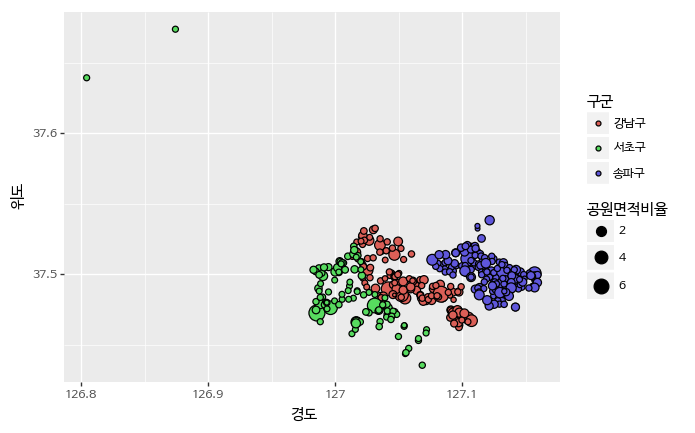

<ggplot: (-9223372036561491719)>

In [64]:
# 서초구 데이터에 잘못된 위경도 데이터가 보입니다. 
(ggplot(geo_df)
 + aes(x='경도', y='위도', fill='구군', size='공원면적비율')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [65]:
geo_df.shape

(387, 13)

In [66]:
map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=13)

for n in geo_df.index:
    park_name = geo_df.loc[n, '공원명'] + ' - ' + geo_df.loc[n, '소재지도로명주소']
    folium.Marker([geo_df.loc[n, '위도'], geo_df.loc[n, '경도']], popup=park_name).add_to(map)
map

### 누락 데이터

* 공공데이터 포털에 확인해 보니 전국도시공원표준데이터.xls 외에 202개의 파일이 더 있습니다.
* https://www.data.go.kr/dataset/15012890/standard.do

* 그럼 서울시에 어린이 공원을 포함해 어떤 공원들이 있는지?

In [67]:
# 서울에는 주로 어떤 공원이 있을까?
seoul['공원구분'].value_counts()

어린이공원     763
근린공원      292
소공원       113
기타         42
역사공원        6
문화공원        6
수변공원        3
도시자연공원      2
도시농업공원      1
기타공원        1
체육공원        1
Name: 공원구분, dtype: int64

In [68]:
# 경기도는 어떨까요?
gg['공원구분'].value_counts()

어린이공원    2037
근린공원      894
소공원       475
문화공원       76
체육공원       73
수변공원       64
역사공원       34
묘지공원       12
기타         10
Name: 공원구분, dtype: int64

In [69]:
park.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '전화번호', '데이터기준일자', '공원면적비율', '시도', '구군'],
      dtype='object')

In [70]:
park_sq = seoul[['시도', '구군', '공원면적']]
park_sq.head()

,시도,구군,공원면적
804,서울특별시,강남구,679.3
1024,서울특별시,강남구,1799.5
1202,서울특별시,강남구,1343.0
1265,서울특별시,강남구,1688.1
1278,서울특별시,강남구,427.6


# 제주도 

In [71]:
jeju = park[park['시도'] == '제주특별자치도']
jeju.shape

(252, 13)

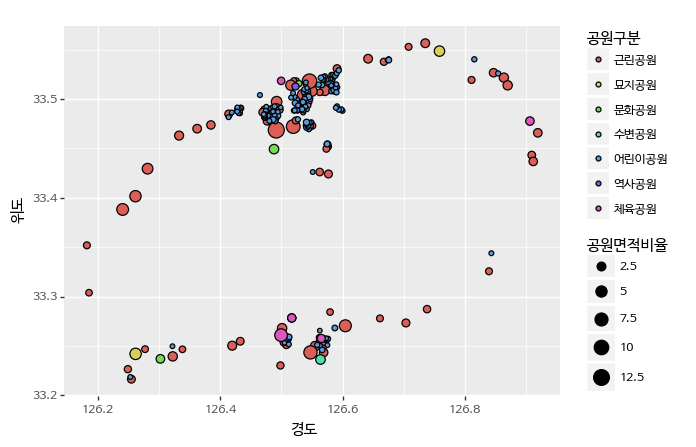

<ggplot: (-9223372036559948102)>

In [72]:
(ggplot(jeju)
 + aes(x='경도', y='위도', fill='공원구분', size='공원면적비율')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [73]:
geo_df = jeju

map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], zoom_start=10)

for n in geo_df.index:
    park_name = geo_df.loc[n, '공원명'] + ' - ' + geo_df.loc[n, '소재지도로명주소']
    icon_color = 'red'
    folium.features.CircleMarker(
        location=[geo_df.loc[n, '위도'], geo_df.loc[n, '경도']],
        radius=geo_df.loc[n, '공원면적비율'],
        popup=park_name,
        color= icon_color,
        fill=True,
        fill_color=icon_color
    ).add_to(map)


map